In [62]:
import torch
import pandas as pd
from ngram_manager import NgramManager
from gensim.models import KeyedVectors
import numpy as np
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import tokenize_uk

In [3]:
class SentenceClassification:
    # 0 - negative
    # 1 - neutral
    # 2 - positive
    def __init__(model):
        self.model = model
        
    
    
    def classify(sentece):
        #TODO:
        return 1

In [186]:
class ClusterNgram:
    def __init__(self, word2vec):
        self.word2vec = word2vec
        
        
    
    def cluster_n_grams(self, ngrams, num_cluster):
        X = self.convert_ngrams_to_vectors(ngrams)
        kclusterer = KMeansClusterer(num_cluster, 
                                     distance=nltk.cluster.util.cosine_distance, 
                                     repeats=10,
                                     avoid_empty_clusters=True)
        y = kclusterer.cluster(X, assign_clusters=True)
        
        top_indices = self.find_top_n_gram_indices(X, y, kclusterer.means())
        
        return np.array(ngrams)[top_indices]
        
        
    
    def find_top_n_gram_indices(self, X, y, centroids):
        min_dis = len(centroids)*[100]
        top_indices = len(centroids)*[-1]
        for i in range(0, len(centroids)):
            for j in range(0, len(X)):
                if y[j] != i:
                    continue
                
                dis = nltk.cluster.util.cosine_distance(X[j], centroids[i])
                if min_dis[i] > dis:
                    min_dis[i] = dis
                    top_indices[i] = j
        
        return top_indices
                    
    
    def convert_ngrams_to_vectors(self, ngrams):
        X = []
        for ngram in ngrams:
            try:
                words = tokenize_uk.tokenize_words(ngram)
                x = word2vec[words[0]]
                for i in range(1, len(words)):
                    x = x + word2vec[words[i]]
                X.append(x)
            except Exception as e:
                print(e)
                X.append(np.zeros(300))
        return X

In [5]:
def read_stop_words(file):
    with open(file) as f:
        stop_words = f.read().split('\n')

    return stop_words

In [8]:
embeddings_file = "/home/dbabenko/Downloads/ubercorpus.cased.tokenized.word2vec.300d"

In [9]:
word2vec = KeyedVectors.load_word2vec_format(embeddings_file)

In [187]:
cluster_ngram = ClusterNgram(word2vec)

In [11]:
pos_unigram_scores = pd.read_csv('./data/unigram-pmi-positive-scores.csv')
pos_bigram_scores = pd.read_csv('./data/bigram-pmi-positive-scores.csv')
pos_trigram_scores = pd.read_csv('./data/trigram-pmi-positive-scores.csv')

In [12]:
neg_unigram_scores = pd.read_csv('./data/unigram-pmi-negative-scores.csv')
neg_bigram_scores = pd.read_csv('./data/bigram-pmi-negative-scores.csv')
neg_trigram_scores = pd.read_csv('./data/trigram-pmi-negative-scores.csv')

In [13]:
uk_stop_words = read_stop_words('./data/ukrainian-stopwords.txt')

In [32]:
pos_ngram_mng = NgramManager(unigram_scores=pos_unigram_scores, 
                             bigram_scores=pos_bigram_scores, 
                             trigram_scores=pos_trigram_scores,
                            stop_words=uk_stop_words,
                            threshold=0.22)

In [33]:
neg_ngram_mng = NgramManager(unigram_scores=neg_unigram_scores, 
                             bigram_scores=neg_bigram_scores, 
                             trigram_scores=neg_trigram_scores,
                            stop_words=uk_stop_words, 
                            threshold=0.22)

In [16]:
df = pd.read_csv('/home/dbabenko/DS/Detect-emotion-sentimental/dataset/booking/booking-train.csv')

In [17]:
df.head()

,title,pos_text,neg_text,ratingValue,bestRating,hotel,rating
0,Лише дівчата на рецепції - три рази мені мінял...,Лише дівчата на рецепції - три рази мені мінял...,"Все. Одного досвіду вистарчило, щоб більше сюд...",4.6,10.0,verhovina.uk.html,2
1,"Оформлення кімнати хороше, досить приємне, на ...","Оформлення кімнати хороше, досить приємне, на ...",Nan,9.2,10.0,verhovina.uk.html,5
2,"Усе відмінно, завдяки якісному сервісу ми завж...","Усе відмінно, завдяки якісному сервісу ми завж...",Рекомендую людям котрі подорожують власним тра...,10.0,10.0,verhovina.uk.html,5
3,Ціна/якість в принципі,Ціна/якість в принципі,"душова, трохи старий ремонт, але за 500 грн за...",7.5,10.0,verhovina.uk.html,4
4,"Приїхали з сином біля сьомої ранку, сонні та в...","Приїхали з сином біля сьомої ранку, сонні та в...",Nan,8.3,10.0,verhovina.uk.html,4


In [21]:
hotel_df = df.loc[df['hotel'] == 'verhovina.uk.html']

In [22]:
hotel_df['pos_text'].values

array(['Лише дівчата на рецепції - три рази мені міняли кімнату. Дякую їм.',
       'Оформлення кімнати хороше, досить приємне, на одну-дві ночі - чудовий варіант, особливо якщо врахувати ціну. Такі номери у конкурентів в два рази дорожчі.',
       "Усе відмінно, завдяки якісному сервісу ми завжди тут зупиняємося. Цього разу ресторан було заброньовано, нам люб'язно запропонували вечерю в номер, це дуже зручно. Надзвичайно люб'язний персонал. Є територія що замикається, для мешканців з авто.",
       ...,
       'Прекрасне місце, чудовий вид. Хороша комната.Буду рекомендувати своїм друзям.',
       'Місце розташування готелю привітний і гостинний персонал хороший wi-fi на 1-му поверсі',
       'Сніданок, чуйність персоналу.'], dtype=object)

In [347]:
ignore_words = ['39', 'язка', 'яке', 'єр', 'інтер', 'язково', 'wifi', 'жд', 'лякливий']

In [348]:
bigrams = set()
for i in range(0, len(hotel_df)):
    tmp_bigrams = pos_ngram_mng.find_important_bigrams(hotel_df['pos_text'].values[i])
    for bigram in tmp_bigrams:
        phrase = bigram[0]
        words = tokenize_uk.tokenize_words(phrase)
        if words[0] not in ignore_words and words[1] not in ignore_words:
            bigrams.add(bigram[0])

/home/dbabenko/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

In [349]:
#result = cluster_ngram.cluster_n_grams(list(bigrams), 10)

In [362]:
k = 5

In [363]:
X =  cluster_ngram.convert_ngrams_to_vectors(list(bigrams))

In [364]:
kclusterer = KMeansClusterer(k, 
                             distance=nltk.cluster.util.cosine_distance, 
                             repeats=20,
                             avoid_empty_clusters=True)
y = kclusterer.cluster(X, assign_clusters=True)
y = np.array(y)

In [365]:
Xy = list(zip(X, list(bigrams)))

In [366]:
embedding_clusters = []
word_clusters = []
cluster_phrases = []
for i in range(0, k):
    tmp = np.array(Xy)[np.where(y==i)].tolist()
    tmp.sort(key = lambda coord: nltk.cluster.util.cosine_distance(coord[0], kclusterer.means()[i]))
    phrases = np.array(tmp)[:5,1]
    word_clusters.append(phrases)
    cluster_phrases.append(phrases[0])
    embeddings = np.array(tmp)[:5,0]
    embedding_clusters.append(embeddings.tolist())


In [367]:
cluster_phrases

['акуратний номер',
 'зручні меблі',
 'гарний затишний',
 'чемний персонал',
 'зручне розташування']

In [368]:
top_indices = cluster_ngram.find_top_n_gram_indices(X, y, kclusterer.means())

In [369]:
top_indices

[485, 374, 355, 246, 371]

In [370]:
np.array(list(bigrams))[top_indices]

array(['акуратний номер', 'зручні меблі', 'гарний затишний',
       'чемний персонал', 'зручне розташування'], dtype='<U27')

In [371]:
from sklearn.manifold import TSNE

In [372]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

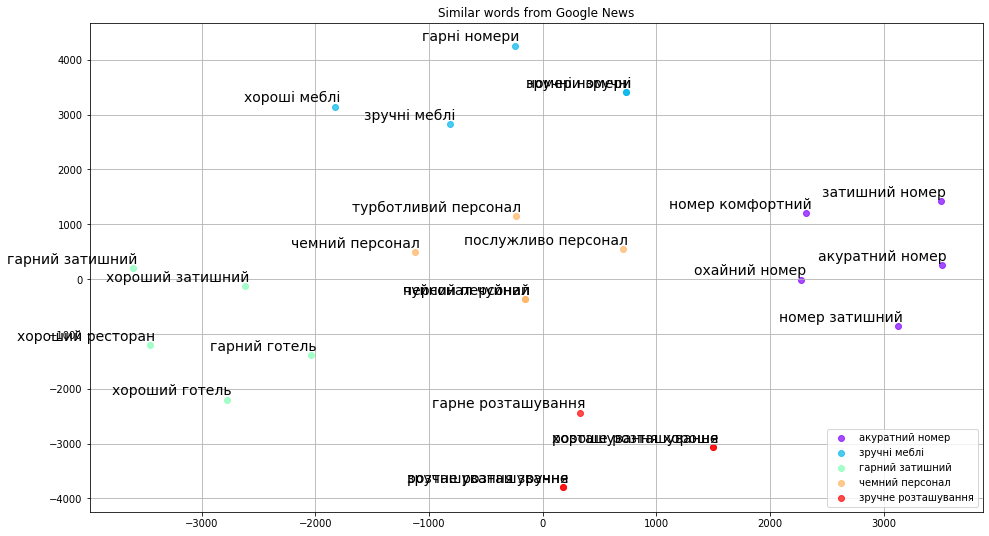

In [373]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.99, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News',cluster_phrases , embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [ ]:
class HotelAnalyzer:
    def __init__(df, pos_ngram_mng, neg_ngram_mng):
        self.df = df
        self.pos_ngram_mng:NgramManager = pos_ngram_mng
        self.neg_ngram_mng:NgramManager = neg_ngram_mng
            
    
    def get_positive_bigrams(hotel_id):
        hotel_df = df.loc[df['hotel'] == hotel_id]
        
        

In [25]:
sentence1 = "Гарний стильний готель, свіжий ремонт, нові меблі (були в номері на 1 поверсі), всього достатньо."

In [26]:
sentecne2 = "Сніданки дійсно смачні."

In [27]:
sentecne3 = "Є бажання повернутися в готель, якщо будемо в Львові"

In [28]:
text = sentence1 + sentecne2 + sentecne3

In [29]:
get_all_ngrams_for_text(text, (2, 2), uk_stop_words)

['бажання повернутися',
 'гарний стильний',
 'готель львові',
 'готель свіжий',
 'достатньо сніданки',
 'меблі номері',
 'нові меблі',
 'номері поверсі',
 'повернутися готель',
 'поверсі достатньо',
 'ремонт нові',
 'свіжий ремонт',
 'смачні бажання',
 'сніданки смачні',
 'стильний готель']

In [33]:
sen1 = "З мінусів: дуже тягло з каналізації неприємний запах."

In [34]:
get_all_ngrams_for_text(sen1, (2, 2), uk_stop_words)

['каналізації неприємний',
 'мінусів тягло',
 'неприємний запах',
 'тягло каналізації']

In [35]:
neg_ngram_mng.find_important_bigrams(sen1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('неприємний запах', 0.34)]

In [15]:
def get_all_ngrams_for_text(text: str, ngram_range, stop_words):
    try:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)
        countvector = vectorizer.fit_transform([text])
        ngrams = vectorizer.get_feature_names()
        return ngrams
    except Exception as e:
        print(e)
        return []

In [18]:
get_all_ngrams_for_text(sentence1, (2, 2), uk_stop_words)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['гарний стильний',
 'готель свіжий',
 'достатньо сніданки',
 'меблі номері',
 'нові меблі',
 'номері поверсі',
 'поверсі достатньо',
 'ремонт нові',
 'свіжий ремонт',
 'сніданки смачні',
 'стильний готель']

In [19]:
pos_ngram_mng.find_important_bigrams(sentence1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('нові меблі', 0.25), ('свіжий ремонт', 0.24), ('сніданки смачні', 0.22)]

In [12]:
import tokenize_uk

In [13]:
class ReviewAnalyzer:
    def __init__(self, sent_cclassifier, pos_ngram_mng, neg_ngram_mng):
        self.pos_ngram_mng = pos_ngram_mng
        self.neg_ngram_mng = neg_ngram_mng
        self.sent_classifier = sent_classifier
        
    
    def analyze_review(text: str):
        
        pos_unigrams, pos_bigrams, pos_trigrams = [], [], []
        neg_unigrams, neg_bigrams, neg_trigrams = [], [], []

        sentences = tokenize_uk.tokenize_sents(text)
        for sent in sentences:
            label = self.sent_classifier(sentences)
            if label == 2:#pos
                pos_unigrams += pos_ngram_mng.find_important_unigrams(sent)
                pos_bigrams += pos_ngram_mng.find_important_bigrams(sent)
                pos_trigrams += pos_ngram_mng.find_important_trigrams(sent)
            elif label == 0: #neg
                neg_unigrams += neg_ngram_mng.find_important_unigrams(sent)
                neg_bigrams += neg_ngram_mng.find_important_bigrams(sent)
                neg_trigrams += neg_ngram_mng.find_important_trigrams(sent)
                
        
        return {
            'pos_unigrams' : pos_unigrams,
            'pos_bigrams' : pos_bigrams,
            'pos_trigrams' : pos_trigrams,
            'neg_unigrams' : neg_unigrams,
            'neg_bigrams' : neg_bigrams,
            'neg_trigrams' : neg_trigrams,
        }

In [49]:
!ls dataset/booking

analyze.ipynb
booking-rating-for-one-hot-test.csv
booking-rating-for-one-hot-train.csv
booking-rating-for-one-hot-val.csv
booking-rating-test.csv
booking-rating-train.csv
booking-rating-val.csv
booking-sentences-test.csv
booking-sentences-train.csv
booking-sentences-val.csv
booking-test.csv
booking-train.csv
booking-val.csv
create-dataset-for-rating-classification.ipynb
create-detect-ngram-dataset.ipynb
create-sentence-classification-dataset.ipynb
dnipro-reviews.csv
ivano-frankivsk-reviews.csv
kharkiv-reviews.csv
kyiv-reviews.csv
lviv-reviews.csv
odesa-reviews.csv
translated
uzhgorod-reviews.csv


In [54]:
booking_df = pd.read_csv('dataset/booking/booking-test.csv')

In [56]:
blum_df = booking_df.loc[booking_df['hotel'] == 'blum.uk.html']

In [57]:
blum_df

,title,pos_text,neg_text,ratingValue,bestRating,hotel,rating
12696,Розташування,Розташування,Брудні і обшарпані стіни номеру Дуже жарко в н...,5.0,10.0,blum.uk.html,2
12697,"Персонал привітний, швидко вирішує усі питання.","Персонал привітний, швидко вирішує усі питання...",Одну з ночей хтось постійно ходив по коридору ...,8.8,10.0,blum.uk.html,4
12698,"Розташування, співвідношення ціни та якості, с...","Розташування, співвідношення ціни та якості, с...","Було б непогано мати чайник в номері, чай та к...",10.0,10.0,blum.uk.html,5
12699,Все супер. Рекомендую,"Знаходиться не далеко від центру, близько всі ...","Запах в номері, якійсь був солодкий, напевно в...",9.2,10.0,blum.uk.html,5
12700,"Хороший готель, схований від шумного центру, т...","Хороший готель, схований від шумного центру, т...","шумоізоляція, та досить велика щілина внизу дв...",9.6,10.0,blum.uk.html,5
12701,Сніданок неперевершений.,Сніданок неперевершений. Необмежена кількість ...,звукоізоляція могла б бути і кращою . Не зайви...,9.2,10.0,blum.uk.html,5
12702,Чудове місце для короткочасних поїздок,"Гарний дизайн готелю, чудове розташування, при...","Сніданок в ціні номеру міг бути більшим, до ка...",8.3,10.0,blum.uk.html,4
12703,Затишний готель у серці Львова;,Затишний готель у серці Львова; привітний нена...,"Сніданок: хотілося б шведський стіл, а не кіль...",8.8,10.0,blum.uk.html,4
12704,наступної мандрівки до Львова оберемо цей готель.,Відмінне розташування готелю! Дуже близько до ...,"один маленький мінус, але нам це не завдало не...",10.0,10.0,blum.uk.html,5
12705,"Сніданок - великі порції, смачно!","Сніданок - великі порції, смачно! 1 страва без...",Сам готель усередині нагадує гуртожиток чи хос...,6.3,10.0,blum.uk.html,3


In [129]:
pos_texts = [text for text in blum_df['neg_text'].values if type(text) is str and text != 'Nan' and len(text) > 0]

In [130]:
pos_texts

['Брудні і обшарпані стіни номеру Дуже жарко в номері Відсутність ліфту Слабий напору води Сейф який нам так і не відкрили, т . б . скористатися ним ми не мали змоги',
 'Одну з ночей хтось постійно ходив по коридору і ми не могли нормально спати через дзвінкий стукіт підборів об плитку . З Комаровим покриттям в коридорі було б комфортніше . Меблі в номері вже трохи втомлені',
 'Було б непогано мати чайник в номері, чай та каву, як це часто буває.',
 'Запах в номері, якійсь був солодкий, напевно від ароматизатор.',
 'шумоізоляція, та досить велика щілина внизу дверей на коридор, коли хтось ходить заважає.. невеликий поріг би виправив це!',
 'звукоізоляція могла б бути і кращою . Не зайвим був би косметичний ремонт номера.',
 "Сніданок в ціні номеру міг бути більшим, до кав'ярні треба йти через вулицю. Надзвичайно тонкі стіни в номерах - чути кожне слово",
 'Сніданок: хотілося б шведський стіл, а не кілька страв на вибір. Дивний душ у номері: важко регулювати температуру води, незручно с

In [131]:
import tokenize_uk

In [132]:
pos_sentences = []
for text in pos_texts:
    pos_sentences += tokenize_uk.tokenize_sents(text)

In [133]:
pos_sentences

['Брудні і обшарпані стіни номеру Дуже жарко в номері Відсутність ліфту Слабий напору води Сейф який нам так і не відкрили, т . б . скористатися ним ми не мали змоги',
 'Одну з ночей хтось постійно ходив по коридору і ми не могли нормально спати через дзвінкий стукіт підборів об плитку .',
 'З Комаровим покриттям в коридорі було б комфортніше .',
 'Меблі в номері вже трохи втомлені',
 'Було б непогано мати чайник в номері, чай та каву, як це часто буває.',
 'Запах в номері, якійсь був солодкий, напевно від ароматизатор.',
 'шумоізоляція, та досить велика щілина внизу дверей на коридор, коли хтось ходить заважає.. невеликий поріг би виправив це!',
 'звукоізоляція могла б бути і кращою .',
 'Не зайвим був би косметичний ремонт номера.',
 "Сніданок в ціні номеру міг бути більшим, до кав'ярні треба йти через вулицю.",
 'Надзвичайно тонкі стіни в номерах - чути кожне слово',
 'Сніданок: хотілося б шведський стіл, а не кілька страв на вибір.',
 'Дивний душ у номері: важко регулювати температ

In [137]:
pos_bigrams = []
for sent in pos_sentences:
    pos_bigrams += neg_ngram_mng.find_important_bigrams(sent)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

In [138]:
len(pos_bigrams)

184

In [107]:
pos_bigrams2 = [bigram[0] for bigram in pos_bigrams if ]

In [118]:
pos_bigrams2 = []
for bigram in pos_bigrams:
    words = tokenize_uk.tokenize_words(bigram[0])
    should_continue = False
    for word in words:
        if word not in word2vec:
            should_continue = True
            break
        if should_continue:
            continue
        pos_bigrams2.append(bigram[0])  
    
    

In [139]:
pos_bigrams2

['персонал привітний',
 'персонал привітний',
 'номері тепло',
 'номері тепло',
 'ліжко зручне',
 'ліжко зручне',
 'чудове розташування',
 'чудове розташування',
 'розташування співвідношення',
 'розташування співвідношення',
 'сучасний інтер',
 'сучасний інтер',
 'співвідношення ціни',
 'співвідношення ціни',
 'ціни якості',
 'ціни якості',
 'інтер єр',
 'інтер єр',
 'шампунь мило',
 'шампунь мило',
 'кондиціонер холодильник',
 'кондиціонер холодильник',
 'обов язково',
 'обов язково',
 'практично центрі',
 'практично центрі',
 'хороший готель',
 'хороший готель',
 'затишне місце',
 'затишне місце',
 'гарний дизайн',
 'гарний дизайн',
 'персонал чистота',
 'персонал чистота',
 'привітний персонал',
 'привітний персонал',
 'розташування привітний',
 'розташування привітний',
 'чудове розташування',
 'чудове розташування',
 'дизайн готелю',
 'дизайн готелю',
 'затишний готель',
 'затишний готель',
 'тихе місце',
 'тихе місце',
 'відмінне розташування',
 'відмінне розташування',
 'розташ

In [155]:
pos_bigrams = [
    'привітний персонал',
    'зручне розташування',
    'співвідношення ціни',
    'тихе місце',
    'смачні сніданки'
]

In [156]:
neg_bigrams = [
    'погана шумоізоляція',
    'тонкі стіни',
    'душова кабіна',
    'відсутність ліфта'
    'запах в номері',
]

In [157]:
print("\n=====Positive summary=====\n")
print(pos_bigrams)

print("\n=====Negative summary=====\n")
print(neg_bigrams)


=====Positive summary=====

['привітний персонал', 'зручне розташування', 'співвідношення ціни', 'тихе місце', 'смачні сніданки']

=====Negative summary=====

['погана шумоізоляція', 'тонкі стіни', 'душова кабіна', 'відсутність ліфтазапах в номері']


In [149]:
word2vec['fi']

array([-1.028050e-01, -1.591530e-01, -2.412480e-01,  4.364560e-01,
        3.575730e-01, -1.874190e-01,  3.456460e-01, -4.303950e-01,
        3.117160e-01, -8.955420e-01, -5.964100e-02, -5.574710e-01,
        2.586510e-01,  4.790900e-01, -1.647780e-01,  1.155010e-01,
       -3.938200e-02,  5.782900e-02, -9.754500e-02,  5.326610e-01,
       -2.315590e-01, -3.967740e-01,  5.405780e-01,  9.064900e-02,
       -4.191140e-01,  4.798320e-01, -6.149540e-01, -9.752500e-02,
       -2.174550e-01,  3.611180e-01, -4.281760e-01, -4.842980e-01,
       -7.256300e-02, -1.807850e-01, -5.743710e-01, -3.599580e-01,
        2.177310e-01,  1.632070e-01, -4.802830e-01, -4.459480e-01,
       -1.990400e-02,  1.715170e-01, -4.212980e-01, -5.607610e-01,
       -4.884900e-01,  5.132700e-01, -1.517100e-01,  9.203550e-01,
       -1.549420e-01,  5.068400e-01, -3.403370e-01, -6.550000e-03,
       -3.348540e-01,  1.614330e-01,  5.414750e-01,  6.156000e-03,
        4.932680e-01,  5.309000e-03, -1.995460e-01, -1.417990e

In [140]:
pos_bigrams

[('номері відсутність', 0.34),
 ('запах номері', 0.33),
 ('косметичний ремонт', 0.31),
 ('тонкі стіни', 0.34),
 ('душ номері', 0.1),
 ('душовій кабіні', 0.33),
 ('душова кабіна', 0.23),
 ('деяких місцях', 0.32),
 ('двері туалет', 0.35),
 ('круті сходи', 0.3),
 ('складно знайти', 0.32),
 ('знайти місце', 0.2),
 ('маленький телевізор', 0.29),
 ('номер вікном', 0.18),
 ('відсутність ліфта', 0.34),
 ('круті сходи', 0.3),
 ('погана шумоізоляція', 0.35),
 ('сусідніх номерах', 0.34),
 ('ванній кімнаті', 0.26),
 ('стіни чути', 0.34),
 ('тонкі стіни', 0.34),
 ('стіни чути', 0.34),
 ('тонкі стіни', 0.34),
 ('чути сусідів', 0.3),
 ('зубної щітки', 0.25),
 ('відсутність шумоізоляції', 0.35),
 ('неможливо спати', 0.34),
 ('душова кабінка', 0.24),
 ('поганому стані', 0.35),
 ('яко кажучи', 0.33),
 ('єдиний мінус', 0.27),
 ('слабка шумоізоляція', 0.35),
 ('останньому поверсі', 0.14),
 ('погана звукоізоляція', 0.35),
 ('спати неможливо', 0.34),
 ('чути розмови', 0.35),
 ('стіни чути', 0.34),
 ('тонкі 

In [ ]:
neg_ngram_mng.find_important_bigrams(ne)

In [127]:
%time result = cluster_ngram.cluster_n_grams(pos_bigrams2, 10)

KeyboardInterrupt: 

In [74]:
tokenize_uk.tokenize_sents(pos_texts[1])

['Персонал привітний, швидко вирішує усі питання.',
 'В номері тепло, ліжко зручне, чисто.',
 'Є необхідна кількість рушників, їх регулярно змінюють.',
 'Є капці.',
 'На столі по пляшці газованої і негазованої води.',
 'Чудове розташування в затишному дворі, повністю відсутній шум з вулиці.']

In [14]:
text = "Готель дуже чудовий, персонал привітний, попросили зробити ранній заїзд з 8 до 9 і нас без питань заселили. При виселенні залишили валізи в кімнаті зберігання. Невеликий мінус це звукоізоляція готелю. Наступний раз виберемо цей готель."

In [15]:
print(text)

Готель дуже чудовий, персонал привітний, попросили зробити ранній заїзд з 8 до 9 і нас без питань заселили. При виселенні залишили валізи в кімнаті зберігання. Невеликий мінус це звукоізоляція готелю. Наступний раз виберемо цей готель.


In [16]:
import tokenize_uk

In [22]:
sentes = tokenize_uk.tokenize_sents(text)

In [20]:
pos_ngram_mng.find_important_bigrams(text)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('чудовий персонал', 0.25),
 ('готель чудовий', 0.23),
 ('персонал привітний', 0.23)]

In [21]:
neg_ngram_mng.find_important_bigrams(text)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[]

In [26]:
pos_sents = [sentes[0], sentes[3]]

In [24]:
neg_sents = [sentes[2]]

In [27]:
pos_sents

['Готель дуже чудовий, персонал привітний, попросили зробити ранній заїзд з 8 до 9 і нас без питань заселили.',
 'Наступний раз виберемо цей готель.']

In [29]:
print("====Positive sentences====")
print(pos_sents)
print("====Negative sentences====")
print(neg_sents)

====Positive sentences====
['Готель дуже чудовий, персонал привітний, попросили зробити ранній заїзд з 8 до 9 і нас без питань заселили.', 'Наступний раз виберемо цей готель.']
====Negative sentences====
['Невеликий мінус це звукоізоляція готелю.']


In [1]:
print("====Positive n-gram====")
print(['готель чудовий', 'персонал привітний'])
print("====Negative n-grams====")
print(['звукоізоляція'])

====Positive n-gram====
['готель чудовий', 'персонал привітний']
====Negative n-grams====
['звукоізоляція']


In [39]:
pos_ngram_mng.find_important_bigrams(text)

TypeError: list indices must be integers or slices, not tuple

In [2]:
print("====Positive n-gram====")
print(['персонал привітний', 'зручне розташування', 'співвідношення ціни', 'тихе місце', 'смачні сніданки'])
print("====Negative n-grams====")
print(['погана шумоізоляція', 'тонкі стіни', 'душова кабіна', 'відсутність ліфта', 'запах номері'])

====Positive n-gram====
['персонал привітний', 'зручне розташування', 'співвідношення ціни', 'тихе місце', 'смачні сніданки']
====Negative n-grams====
['погана шумоізоляція', 'тонкі стіни', 'душова кабіна', 'відсутність ліфта', 'запах номері']


In [41]:
neg_text = "Одну з ночей хтось постійно ходив по коридору і ми не могли нормально спати через дзвінкий стукіт підборів об плитку. З ковровим покриттям в коридорі було б комфортніше. Меблі в номері вже трохи втомлені"

In [44]:
neg_ngram_mng.find_important_unigrams(neg_text)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('коридору', 0.31),
 ('хтось', 0.31),
 ('могли', 0.28),
 ('спати', 0.28),
 ('коридорі', 0.27),
 ('постійно', 0.25),
 ('нормально', 0.16),
 ('номері', 0.11)]